In [1]:
# Load example subjects

import pickle
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))
fc = []
age = []

for sub in demo['Age_cal']:
    fc.append(np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy'))
    age.append(demo['Age_cal'][sub])
    
fc = np.stack(fc)
age = np.array(age)
print(fc.shape, age.shape)

(1244, 34716) (1244,)


In [119]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class LatSim(nn.Module):
    def __init__(self):
        super(LatSim, self).__init__()
        self.A = nn.Parameter(0.01*torch.randn(1,264,20).float().cuda())
        self.b = nn.Parameter(0.1*torch.randn(264,20).float().cuda())
        self.i, self.j = np.triu_indices(264,1)
        
    def gen(self):
        A = torch.einsum('abc,adc->bda', self.A, self.A)
        b = torch.einsum('bc,dc->bd', self.b, self.b)
        return A[self.i,self.j], b[self.i,self.j].unsqueeze(0)
        
    def forward(self, xtr, y, xt=None):
        A, b = self.gen()
        if xt is None:
            xt = xtr
        z1 = torch.einsum('nf,fd->nd',xtr-b,A)
        z2 = torch.einsum('nf,fd->nd',xt-b,A)
        E = z2@z1.T
        E = F.softmax(E, dim=1)
        return E@y
    
print('Complete')

Complete


In [121]:
import sys

path = '/home/anton/Documents/Tulane/Research/LatentSimilarity/'

if path not in sys.path:
    sys.path.append(path)
    
print(sys.path)

['/home/anton/Documents/Tulane/Research/code/ContrastiveLearning', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/lib/python3.11/site-packages', '/home/anton/Documents/Tulane/Research/LatentSimilarity/']


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from latsim import LatSimReg

nepochs = 400
pperiod = 50

xtr, xt, ytr, yt = [x for x in train_test_split(fc, age, train_size=0.6)]

# mu = torch.mean(xtr, dim=0, keepdims=True)
# xtr = xtr-mu
# xt = xt-mu

reg = Ridge(alpha=1).fit(xtr, ytr)
yhat = reg.predict(xt)
print(np.mean((yhat-yt)**2)**0.5)

reg = LatSimReg(alpha=1).fit(xtr, ytr)
yhat = reg.predict(xt)
print(np.mean((yhat-yt)**2)**0.5)

raise 'bad'

sim = LatSim()
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

for e in range(nepochs):
    optim.zero_grad()
    yhat = sim(xtr, ytr)
    loss = torch.mean((ytr-yhat)**2)**0.5
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')
        
yhat = sim(xtr, ytr, xt)

with torch.no_grad():
    rmse = torch.mean((yt-yhat)**2)**0.5
    print(rmse)

/usr/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


10.358531402026209
10.454859714938264


TypeError: exceptions must derive from BaseException

In [51]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


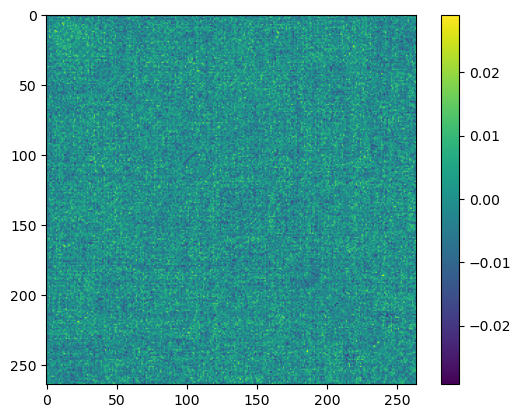

In [131]:
import matplotlib.pyplot as plt

# A, b = [x.squeeze().detach().cpu().numpy() for x in sim.gen()]

plt.imshow(remap(vec2mat(reg.sim.A[:,0].detach().cpu().numpy())))
plt.colorbar()
plt.show()

In [126]:
reg.sim.A

Parameter containing:
tensor([[-0.0075, -0.0013],
        [-0.0033, -0.0031],
        [-0.0054,  0.0038],
        ...,
        [ 0.0046, -0.0099],
        [-0.0035,  0.0048],
        [-0.0051, -0.0063]], device='cuda:0', requires_grad=True)